In [ ]:
The cosmology is Rh=ct cosmology. DL=(1+z)*(c/H0)*ln(1+z), calculate the conditonal prior DL for H_0 P(dl|H_0) and normolization;
Given DL H0 solve z need the lamvert w function;
c_l is the speed of light 3*10^5 km/s

In [145]:
import numpy as np
import bilby
from scipy import interpolate
from matplotlib import pyplot as plt
import random
from scipy import integrate
from scipy.special import lambertw
#####################################
outdir='outdir'
c_l=3*10**5
def ogetz(dl,H0):
    '''
    dl is the luminosity distance
    H0 is the Hubble constant
    return reshift z given H0 dl
    '''
    t=dl*H0/(3*10**5)
    return (np.exp(lambertw(t))-1).real
def PDL(DL,H0):
    '''
    prior for DL
    return probability
    '''
    z=ogetz(DL,H0)
    return (DL*DL)/((1+z)**3)
def normPDL(DL,H0):
    '''
    Normalize the prior for DL
    Normalize area DL [0,30400Mpc]
    '''
    ss=np.trapz(PDL(np.arange(0,30400,100),H0),np.arange(0,30400,100))
    return PDL(DL,H0)/ss  

P(m1),P(m2) source frame
the prior for m1 m2 in source frame, according Colm&Eric paper
the ture value for parameter form Colm&Eric paper and Rory's code

In [167]:
#mmin is the min value for m1
alpha=1.5
mmax=40
lamda=0.1
mpp=35
deltapp=1.0
beta=-0.2
mmin=8
deltam=0.1
def fm(m):
    return deltam/(m)-(deltam/((m-deltam)))
def Sm(m):
    return 1/(np.exp(fm(m-2.901))+1)
def ppow(m):
    return (m**(-1*alpha))*Sm(m)
def ppp(m):
    return np.exp(-1*(m-mpp)**2/(2*deltapp*deltapp))*Sm(m)
def Pm1(m):
    return ((1-lamda)*ppow(m)+lamda*ppp(m))
def Pm2(m2,m):
    return ((m2/m)**beta)*Sm(m2)
def normPm1(m):
    ss=np.trapz(Pm1(np.arange(mmin,40.5,0.5)),np.arange(mmin,40.5,0.5))
    return (Pm1(m)/ss)
def normPm2(m2,m):
    ss=np.trapz(Pm2(np.arange(mmin,40.5,0.5),40),np.arange(mmin,40.5,0.5))
    return Pm2(m2,m)/ss

According to the prior to generate the mock data samples DL m1 m2;
The number of event is choiceN;
deltadl is the step for DL; 

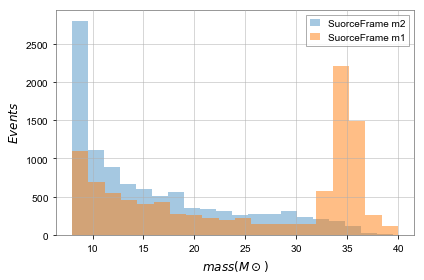

In [169]:
choiceN=10000
deltadl=30
sampdl = random.choices(np.arange(1,30030,deltadl),PDL(np.arange(1,30030,deltadl),70), k=choiceN)
sampz=ogetz(np.array(sampdl),70) #rhct cosmology
sampm1 = random.choices(np.arange(8,40.5,0.5),Pm1(np.arange(8,40.5,0.5)), k=choiceN)
sampm1z=(np.array(sampz)+1)*np.array(sampm1)
temsampm2=np.zeros((choiceN,1))
for i in range(choiceN):
    temsampm2[i,:] = random.choices(np.arange(8,(sampm1[i]+0.5),0.5),Pm2(np.arange(8,(sampm1[i]+0.5),0.5),sampm1[i]),k=1)
sampm2=temsampm2.flatten()
sampm2z=np.array(sampm2)*((np.array(sampz)+1))
sampq=sampm2/sampm1
sampdl=np.array(sampdl)
sampm1z=np.array(sampm1z)
sampm2z=np.array(sampm2z)
plt.hist(sampm2,20,alpha=0.4,density=False,label='SuorceFrame m2')
plt.hist(sampm1,20,alpha=0.5,density=False,label='SuorceFrame m1')
plt.legend(prop={'size': 16})
plt.xlabel(r'$mass(M\odot)$')
plt.ylabel(r'$Events$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

According to prior for the other 12 parameters a_1 a_2 ......;
the prior form bilby.gw.prior;
add the samples DL m1 m2 to the other 12 parameters samples;
return: [events x 15] array txt file, event=10000;

In [ ]:
label = 'samplesdata'
bilby.core.utils.setup_logger(outdir=outdir, label=label)
duration = 4
sampling_frequency = 2048
geocent_time_random=np.random.uniform(10**9,10**10,choiceN)
a_1_prior         =bilby.gw.prior.Uniform(minimum=0, maximum=0.8, name='a_1', latex_label='$a_1$', unit=None, periodic_boundary=False)
a_2_prior         =bilby.gw.prior.Uniform(minimum=0, maximum=0.8, name='a_2', latex_label='$a_2$', unit=None, periodic_boundary=False)
tilt_1_prior      =bilby.core.prior.Sine(name='tilt_1', latex_label='$\\theta_1$', unit=None, minimum=0, maximum=3.141592653589793, periodic_boundary=False)
tilt_2_prior      =bilby.core.prior.Sine(name='tilt_1', latex_label='$\\theta_1$', unit=None, minimum=0, maximum=3.141592653589793, periodic_boundary=False)
phi_12_prior      =bilby.gw.prior.Uniform(minimum=0, maximum=6.283185307179586, name='phi_12', latex_label='$\\Delta\\phi$', unit=None, periodic_boundary=True)
phi_jl_prior      =bilby.gw.prior.Uniform(minimum=0, maximum=6.283185307179586, name='phi_jl', latex_label='$\\phi_{JL}$', unit=None, periodic_boundary=True)
theta_jn_prior    =bilby.core.prior.Sine(name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, minimum=0, maximum=3.141592653589793, periodic_boundary=False)
psi_prior         =bilby.gw.prior.Uniform(minimum=0, maximum=3.141592653589793, name='psi', latex_label='$\\psi$', unit=None, periodic_boundary=True)
phase_prior       =bilby.gw.prior.Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, periodic_boundary=True)
geocent_time_prior=bilby.gw.prior.Uniform(minimum=geocent_time_random- 1,maximum=geocent_time_random + 1,name='geocent_time', latex_label='$t_c$', unit='$s$')
ra_prior          =bilby.gw.prior.Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, periodic_boundary=True)
dec_prior         =bilby.core.prior.Cosine(name='dec', latex_label='$\\mathrm{DEC}$', unit=None, minimum=-1.5707963267948966, maximum=1.5707963267948966, periodic_boundary=False)
kk=choiceN#number of event
inpa=np.zeros((kk,15))
smaples_a_1 = a_1_prior.sample(kk)
smaples_a_2 = a_2_prior.sample(kk)
smaples_tilt_1 = tilt_1_prior.sample(kk)
smaples_tilt_2 = tilt_2_prior.sample(kk)
smaples_phi_12 = phi_12_prior.sample(kk)
smaples_phi_jl = phi_jl_prior.sample(kk)
smaples_theta_jn = theta_jn_prior.sample(kk)
smaples_psi = psi_prior.sample(kk)
smaples_phase = phase_prior.sample(kk)
smaples_geocent_time = geocent_time_prior.sample(kk)
smaples_ra = ra_prior.sample(kk)
smaples_dec = dec_prior.sample(kk)
inpa[:,0]=sampm1z#samples_mass_1
inpa[:,1]=sampm2z#smaples_mass_2
inpa[:,2]=smaples_a_1
inpa[:,3]=smaples_a_2
inpa[:,4]=smaples_tilt_1
inpa[:,5]=smaples_tilt_2
inpa[:,6]=smaples_phi_12
inpa[:,7]=smaples_phi_jl
inpa[:,8]=sampdl#smaples_luminosity_distance
inpa[:,9]=smaples_theta_jn
inpa[:,10]=smaples_psi
inpa[:,11]=smaples_phase
inpa[:,12]=smaples_geocent_time
inpa[:,13]=smaples_ra
inpa[:,14]=smaples_dec
np.savetxt('RHCTcosmology15p.txt',inpa)